In [47]:
!pip install fastapi uvicorn yfinance nest_asyncio

In [48]:
from fastapi import FastAPI
import yfinance as yf
import uvicorn
import nest_asyncio
import warnings
import pandas as pd

In [49]:
def get_stock_info(ticker):
    stock = yf.Ticker(ticker)
    info = stock.info
    market_cap = info.get('marketCap', 0)
    sector = info.get('sector', 'N/A')
    industry = info.get('industry', 'N/A')
    return market_cap, sector, industry

def get_stock_balance_sheet(ticker):
    stock = yf.Ticker(ticker)
    bs = stock.balance_sheet
    total_debt = bs.loc["Total Debt"].iloc[0] if "Total Debt" in bs.index else 0
    cash_and_equiv = bs.loc["Cash And Cash Equivalents"].iloc[0] if "Cash And Cash Equivalents" in bs.index else 0
    receivables = bs.loc["Receivables"].iloc[0] if "Receivables" in bs.index else 0
    return total_debt, cash_and_equiv, receivables

def get_stock_financials(ticker):
    stock = yf.Ticker(ticker)
    fin = stock.financials
    revenue = fin.loc["Total Revenue"].iloc[0] if "Total Revenue" in fin.index else 0
    interest_income = fin.loc["Interest Income"].iloc[0] if "Interest Income" in fin.index else 0
    return revenue, interest_income

def get_stock_cash_flow(ticker):
    stock = yf.Ticker(ticker)
    cf = stock.cashflow
    if 'Total Cash From Operating Activities' in cf.index:
      return cf.loc['Total Cash From Operating Activities'].iloc[0]
    return None # Or return cf for full dataframe

In [50]:
DEBT_LIMIT = 0.30
CASH_LIMIT = 0.30
RECEIVABLE_LIMIT = 0.45
PROHIBITED_REV_LIMIT = 0.50

def get_financial_data(ticker):
  # Fetch data using the new modular functions
  market_cap, sector, industry = get_stock_info(ticker)
  total_debt, cash_and_equiv, receivables = get_stock_balance_sheet(ticker)
  revenue, interest_income = get_stock_financials(ticker)
  # cash_flow_data = get_stock_cash_flow(ticker) # Not directly used in the return values for shariah_screen

  return market_cap, total_debt, cash_and_equiv, receivables, revenue, interest_income, sector, industry


In [51]:
def shariah_screen(ticker):
  market_cap, debt, cash, receivables, revenue, interest_income, sector, industry = get_financial_data(ticker) # Unpack industry

  if market_cap == 0:
    return None

  debt_ratio = debt / market_cap
  cash_ratio = cash / market_cap
  receivables_ratio = receivables / market_cap
  prohibited_ratio = interest_income / revenue if revenue != 0 else 0

  status = all([
    debt_ratio <= DEBT_LIMIT,
    cash_ratio <= CASH_LIMIT,
    receivables_ratio <= RECEIVABLE_LIMIT,
    prohibited_ratio <= PROHIBITED_REV_LIMIT
  ])

  return {
    "Ticker": ticker,
    "Debt Ratio": debt_ratio,
    "Cash Ratio": cash_ratio,
    "Receivables Ratio": receivables_ratio,
    "Prohibited Revenue Ratio": prohibited_ratio,
    "Sector": sector, # Added sector information
    "Industry": industry,
    "Status": "COMPLIANT" if status else "NON-COMPLIANT",
  }

In [52]:
# List of Indonesian tickers to screen
tickers = ["DSSA.JK", "TPIA.JK", "AMMN.JK", "DCII.JK", "BYAN.JK", "TLKM.JK",
           "CUAN.JK", "SRAJ.JK", "PANI.JK", "BRPT.JK", "MORA.JK"]
results = []
for t in tickers:
  print(f"Screening {t}...")
  res = shariah_screen(t)
  if res:
    results.append(res)

df = pd.DataFrame(results)
df

Screening DSSA.JK...
Screening TPIA.JK...
Screening AMMN.JK...
Screening DCII.JK...
Screening BYAN.JK...
Screening TLKM.JK...
Screening CUAN.JK...
Screening SRAJ.JK...
Screening PANI.JK...
Screening BRPT.JK...
Screening MORA.JK...


,Ticker,Debt Ratio,Cash Ratio,Receivables Ratio,Prohibited Revenue Ratio,Sector,Industry,Status
0,DSSA.JK,2.258872e-06,0.000002,0.000000,0.020632,Energy,Thermal Coal,COMPLIANT
1,TPIA.JK,3.439028e-06,0.000002,0.000000,0.053196,Basic Materials,Specialty Chemicals,COMPLIANT
2,AMMN.JK,7.480401e-06,0.000001,0.000000,0.000000,Basic Materials,Other Precious Metals & Mining,COMPLIANT
3,DCII.JK,2.065199e-03,0.000422,0.000000,0.005365,Technology,Information Technology Services,COMPLIANT
4,BYAN.JK,7.207297e-07,0.000002,0.000000,0.008068,Energy,Thermal Coal,COMPLIANT
5,TLKM.JK,2.228775e-01,0.098350,0.044318,0.009115,Communication Services,Telecom Services,COMPLIANT
6,CUAN.JK,4.185529e-06,0.000001,0.000000,0.004687,Energy,Thermal Coal,COMPLIANT
7,SRAJ.JK,8.523713e-03,0.001416,0.000000,0.004283,Healthcare,Medical Care Facilities,COMPLIANT
8,PANI.JK,4.067103e-03,0.022579,0.000000,0.061255,Real Estate,Real Estate - Development,COMPLIANT
9,BRPT.JK,2.452907e-05,0.000008,0.000000,0.053964,Basic Materials,Chemicals,COMPLIANT


Visualisasi Saham Berdasarkan Sektor dan Status Kepatuhan Syariah.

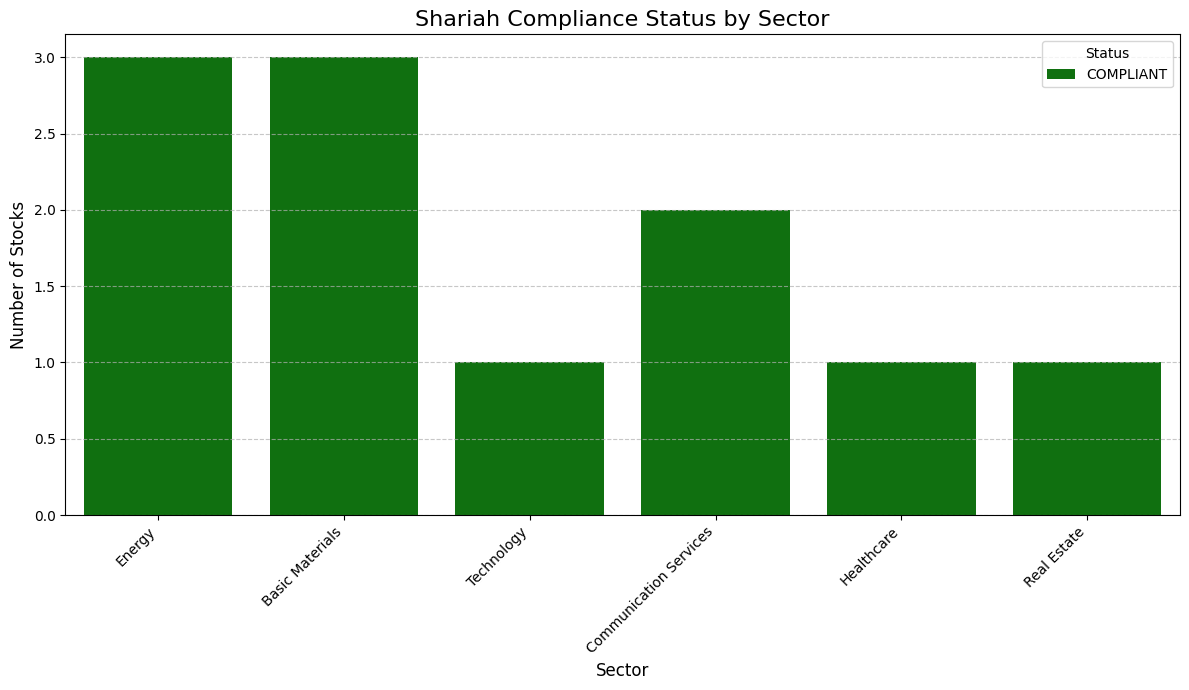

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure df is available (from cell b2u8rk82edDJ)

plt.figure(figsize=(12, 7))
sns.countplot(data=df, x='Sector', hue='Status', palette={'COMPLIANT': 'green', 'NON-COMPLIANT': 'red'})
plt.title('Shariah Compliance Status by Sector', fontsize=16)
plt.xlabel('Sector', fontsize=12)
plt.ylabel('Number of Stocks', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Status')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Visualisasi Rasio Keuangan Terhadap Batas Ambang Kepatuahan Syariah.

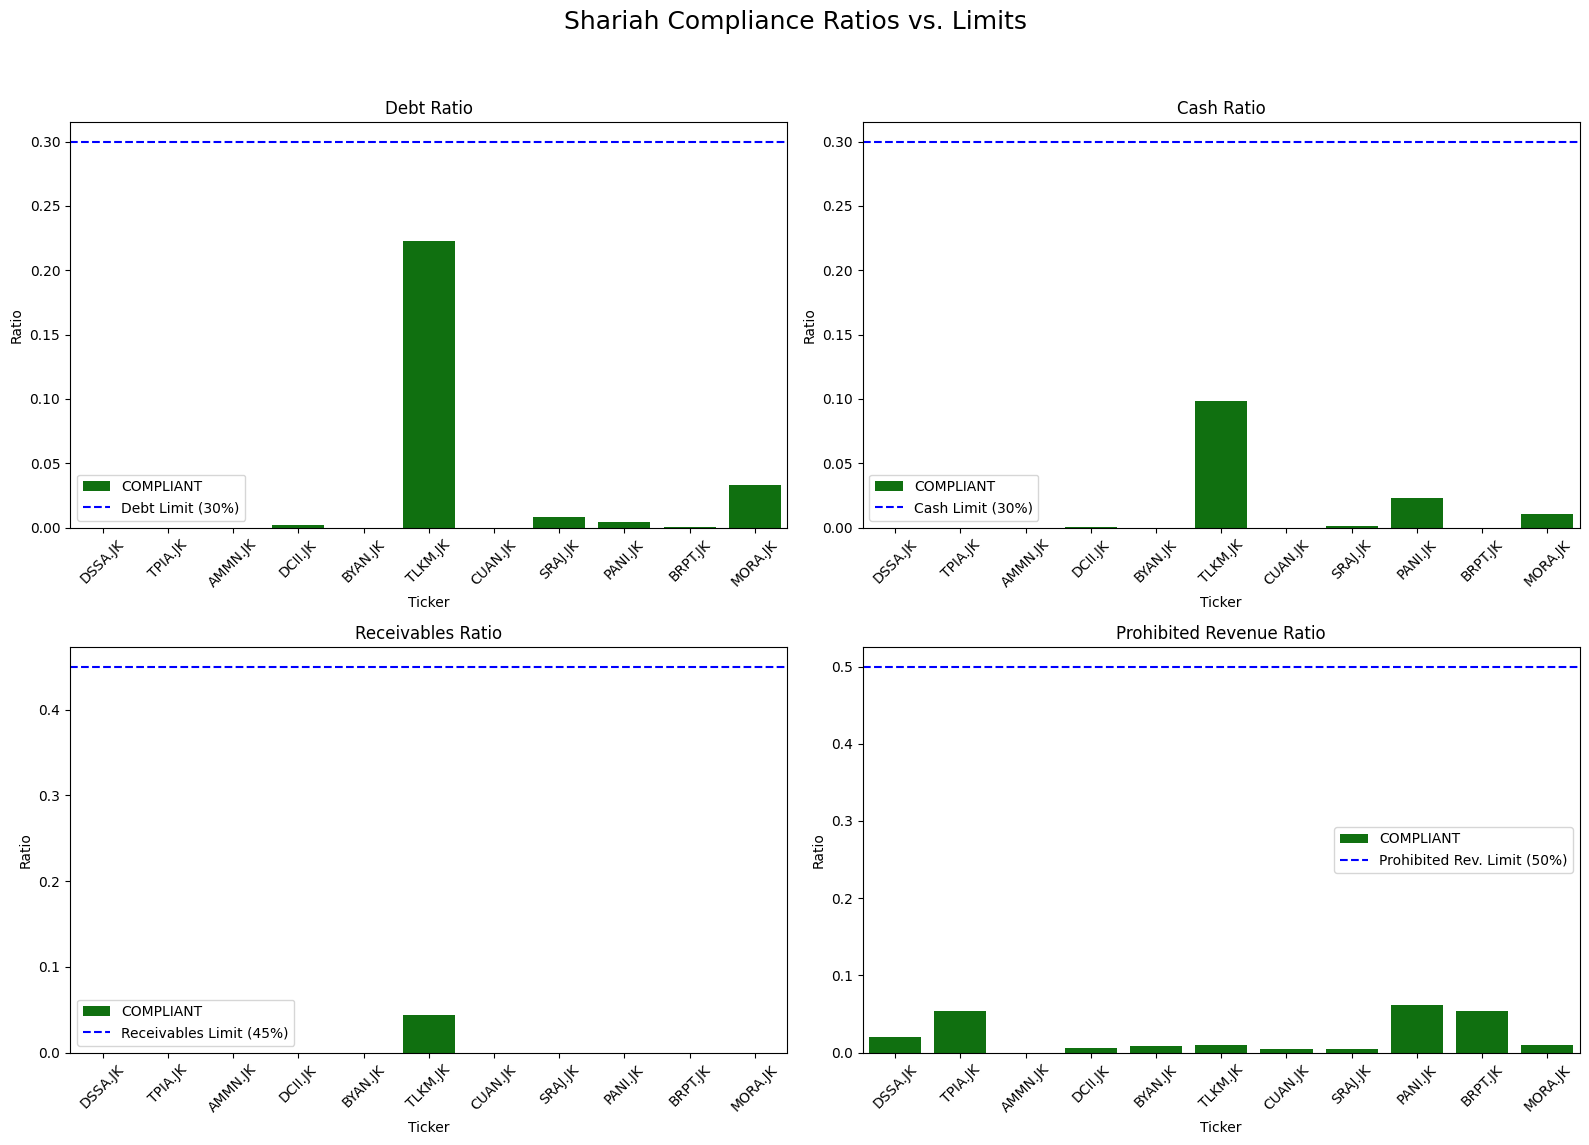

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure the df DataFrame is available (from previous execution)
# If not, ensure the shariah_screen function and data fetching are executed first

# Define the limits (already defined as global variables, but good to have context)
# DEBT_LIMIT, CASH_LIMIT, RECEIVABLE_LIMIT, PROHIBITED_REV_LIMIT

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Shariah Compliance Ratios vs. Limits', fontsize=18)

# Debt Ratio
sns.barplot(ax=axes[0, 0], x='Ticker', y='Debt Ratio', hue='Status', data=df, palette={'COMPLIANT': 'green', 'NON-COMPLIANT': 'red'})
axes[0, 0].axhline(y=DEBT_LIMIT, color='blue', linestyle='--', label=f'Debt Limit ({DEBT_LIMIT:.0%})')
axes[0, 0].set_title('Debt Ratio')
axes[0, 0].legend()
axes[0, 0].set_ylabel('Ratio')
axes[0, 0].tick_params(axis='x', rotation=45)

# Cash Ratio
sns.barplot(ax=axes[0, 1], x='Ticker', y='Cash Ratio', hue='Status', data=df, palette={'COMPLIANT': 'green', 'NON-COMPLIANT': 'red'})
axes[0, 1].axhline(y=CASH_LIMIT, color='blue', linestyle='--', label=f'Cash Limit ({CASH_LIMIT:.0%})')
axes[0, 1].set_title('Cash Ratio')
axes[0, 1].legend()
axes[0, 1].set_ylabel('Ratio')
axes[0, 1].tick_params(axis='x', rotation=45)

# Receivables Ratio
sns.barplot(ax=axes[1, 0], x='Ticker', y='Receivables Ratio', hue='Status', data=df, palette={'COMPLIANT': 'green', 'NON-COMPLIANT': 'red'})
axes[1, 0].axhline(y=RECEIVABLE_LIMIT, color='blue', linestyle='--', label=f'Receivables Limit ({RECEIVABLE_LIMIT:.0%})')
axes[1, 0].set_title('Receivables Ratio')
axes[1, 0].legend()
axes[1, 0].set_ylabel('Ratio')
axes[1, 0].tick_params(axis='x', rotation=45)

# Prohibited Revenue Ratio
sns.barplot(ax=axes[1, 1], x='Ticker', y='Prohibited Revenue Ratio', hue='Status', data=df, palette={'COMPLIANT': 'green', 'NON-COMPLIANT': 'red'})
axes[1, 1].axhline(y=PROHIBITED_REV_LIMIT, color='blue', linestyle='--', label=f'Prohibited Rev. Limit ({PROHIBITED_REV_LIMIT:.0%})')
axes[1, 1].set_title('Prohibited Revenue Ratio')
axes[1, 1].legend()
axes[1, 1].set_ylabel('Ratio')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent suptitle overlap
plt.show()
